In [ ]:
import pandas as pd

In [5]:
df = pd.read_csv('BachelorArbeit_datensatz.csv', encoding='utf-16', delimiter='\t', quotechar='"')

df_brandinfo = pd.read_csv('Brandinformationen.csv', encoding='utf-8', delimiter=';', quotechar='"')

# Merging df and df_brandinfo
combined_df = pd.merge(df, df_brandinfo, left_on='BA01', right_on='BA_Kennung')

# Creating 'brandPost' column based on 'LANGUAGE' column in df
combined_df['brandPost'] = combined_df.apply(lambda row: row['Brandtext_DE'] if row['LANGUAGE'] == 'DE' else row['Brandtext_EN'], axis=1)

# Creating final_df with the relevant columns
final_df = combined_df[df.columns.tolist() + ['brandPost']]


In [7]:
## Cleaning the data

## TOO FAST
# Remove rows where 'TIME_RSI' is equal to or greater than 2
print(f"Number of rows in df_final before before removal: {len(final_df)}")

final_df = final_df[final_df['TIME_RSI'] < 1.95]


## SPAM / THINK, FEEL, COMMENT, SAME THING

# Create 'EveryComment' and 'CommentType' columns as previously discussed
final_df['EveryComment'] = final_df['TR01_01'].fillna(final_df['TR06_01'])
final_df['CommentType'] = ['voluntary' if pd.notna(tr01) else 'forced' 
                           for tr01 in final_df['TR01_01']]

# Check for duplicates in 'EveryComment', 'TR05_01', and 'TR05_02' columns
duplicate_EveryComment = final_df['EveryComment'].duplicated(keep=False)
duplicate_TR05_01 = final_df['TR05_01'].duplicated(keep=False)
duplicate_TR05_02 = final_df['TR05_02'].duplicated(keep=False)

# Identify rows where there are duplicates in 'EveryComment', 'TR05_01', and 'TR05_02'
duplicate_all_columns = duplicate_EveryComment & duplicate_TR05_01 & duplicate_TR05_02

# Remove rows with duplicates in all three columns from df_final
final_df_cleaned = final_df[~duplicate_all_columns]


## COMMENT TOO SHORT – TRIED TO GET TO RAFFLE

final_df_cleaned = final_df_cleaned[final_df_cleaned['EveryComment'].str.len() >= 3]


# Calculating the Average and inserting 'CE_measure' as a variable
columns_to_average = ['CE01_01', 'CE01_02', 'CE01_03', 'CE01_04']

final_df_cleaned['CE_measure'] = final_df_cleaned[columns_to_average].mean(axis=1)

idx = final_df_cleaned.columns.get_loc('CE01_04') + 1
final_df_cleaned.insert(loc=idx, column='CE_measure_temp', value=final_df_cleaned['CE_measure'])

final_df_cleaned = final_df_cleaned.drop(columns=['CE_measure'])
final_df_cleaned = final_df_cleaned.rename(columns={'CE_measure_temp': 'CE_measure'})


## UNREASONABLE CE MEASURE FOR NON COGNITIVE COMMENT
final_df_cleaned = final_df_cleaned[~((final_df_cleaned['EveryComment'].str.len() < 5) & (final_df_cleaned['CE_measure'] > 5))]


# Print the number of rows remaining to confirm the operation
print(f"Number of rows in df_final before removal: {len(final_df)}")
print(f"Number of rows in df_final_cleaned after removal: {len(final_df_cleaned)}")


Number of rows in df_final before before removal: 614
Number of rows in df_final before removal: 563
Number of rows in df_final_cleaned after removal: 406


# Column names I need:

**Cognitive Engagement Scale**

CE_measure: CE Measure overall

CE01_01: CE ITEM1 (Wenn ich etwas zu dieser Marke lese, vergesse ich alles um mich herum)

CE01_02: CE ITEM2 (darüber nachgedacht, wie dieser Beitrag mit anderen Dingen zusammenhängt, die ich bereits kenne)

CE01_03: CE ITEM3 (Ich habe die Botschaft der Marke mit großer Aufmerksamkeit verfolgt)

CE01_04: CE ITEM4 (Ich denke, ich werde die Botschaft der Marke noch länger im Kopf behalten)


**Comments & Thoughts**

TR01_01: Voluntary Comment

TR06_01: Mandatory Comment

TR05_01: Thoughts while commenting

TR05_02: Feelings while commenting



In [ ]:
## OPENAI API CALL 

!pip install openai==0.28

import openai

# Set your OpenAI API key
openai.api_key = 'APIKEY'

# Define a function to construct your prompt
def create_prompt(brand_text, comment):
    prompt_text = f"Assess the cognitive engagement of this user comment in relation to the specified LinkedIn brand post, based on the outlined dimensions. Comment: '{comment}'. LinkedIn post: '{brand_text}'. Provide a cognitive engagement rating as a single number, representing the average across the four dimensions, rounded to two decimal places. Only consider comments and posts in English or German, and interpret described emojis accordingly. Only give back a single number rounded to two decimal places, explanation or commentary on the previous dimensions will be punished."
    return prompt_text

# Initialize a list to store the responses
responses = []

#DELETE FOR REAL THING
counter = 0

# Iterate over each row in the DataFrame
for index, row in final_df_cleaned.iterrows():

    brand_text = row['brandPost']
    comment = row['EveryComment']

    # Construct the prompt
    prompt_text = create_prompt(brand_text, comment)

    # Send the prompt to the OpenAI API
    response = openai.ChatCompletion.create(
        model="gpt-4-1106-preview",  # Specify the correct model here
        messages=[
            {"role": "system", "content": "You are an AI designed to assess cognitive engagement in social media comments on LinkedIn. Analyze comments using a 1-7 Likert-scale on four key dimensions: ### 1. Attention: Rate higher for comments showing detailed understanding, such as referencing specific elements of the brand post. 2. Absorption: High scores for comments showing high-level abstraction or innovative thoughts about the brand post. 3. Connection of New Ideas: Evaluate how users relate the post to their personal experiences or external knowledge. More creative and insightful connections score higher. 4. Retention: Assess for potential long-term impact, like comments with unique perspectives or those indicating lasting memory. ### Assumptions about cognitive engagement beyond these guidelines will be punished. Rate each dimension and calculate the average, rounded to two decimal places. Examples: 'A smiley emoji’ (1-2). 'Very cool ideas. This would be fun to recreate. {EM_SMILING_FACE}️' should rate higher (5-7). Assume log normal distribution in the ratings over long term. If a comment is off-topic, spam, or explicitly states non-engagement, return 'invalid' – do not choose that option slightly. Return one number rounded to two decimal places. Do not include explanation of every dimension in the response."},
            {"role": "user", "content": prompt_text}
        ],
        max_tokens=500,
        temperature=0.5
    )

    # Extract and append the response text to the responses list
    responses.append(response['choices'][0]['message']['content'])

# After generating responses for Xcounter rows
remaining_rows = len(final_df_cleaned) - len(responses)
responses.extend([None] * remaining_rows)  # Fill the rest of the responses with None

# Now add the responses to the DataFrame
final_df_cleaned['GPT_Measure_CE'] = responses

In [243]:
import pandas as pd
import re

# Assuming 'final_df_cleaned' is your DataFrame
# Replace the below line with your actual DataFrame
# final_df_cleaned = ...

# Function to calculate the modified length of each comment
def calculate_length(comment):
    modified_comment = re.sub(r'\{.*?\}', 'X', comment)  # Replace text within {} with 'X'
    return len(modified_comment)

# Apply the function to the 'EveryComment' column and create the 'Length' column
final_df_cleaned['Length'] = final_df_cleaned['EveryComment'].apply(calculate_length)

# Now 'final_df_cleaned' contains the new 'Length' column

In [ ]:
final_df_cleaned[['BA01', 'EveryComment', 'CE_measure', 'GPT_Measure_CE']].tail(20)

## if too long too read
#for index, value in final_df_cleaned['GPT_Measure_CE'].items():
  #  print(f"Index {index}: {value}")


In [ ]:
final_df_cleaned[['BA01', 'EveryComment', 'CE_measure', 'GPT_Measure_CE', 'Length']].tail(20)

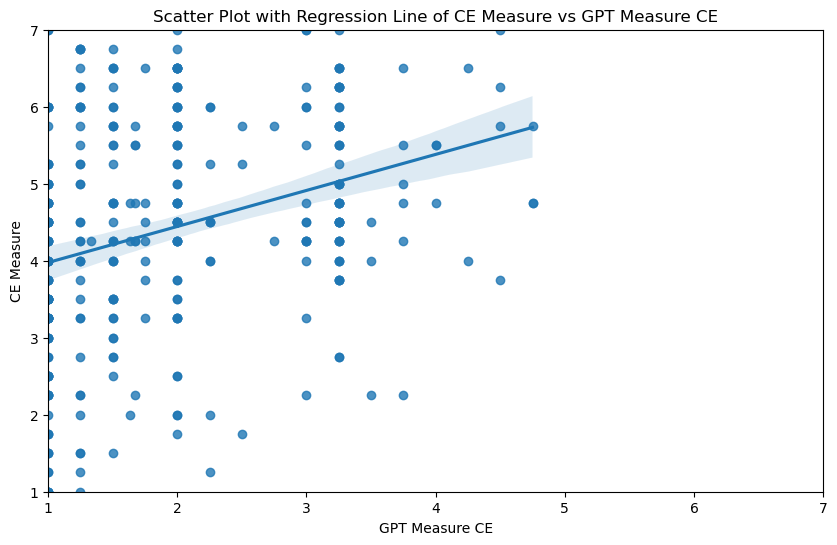

In [224]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_df_cleaned' is your DataFrame
# Replace the below line with your actual DataFrame
# final_df_cleaned = ...

# Function to check if a value can be converted to float
def is_float(value):
    if value is None:
        return False
    try:
        float(value)
        return True
    except ValueError:
        return False


# Filter rows where both CE_measure and GPT_Measure_CE can be converted to float
# Filter rows where both CE_measure and GPT_Measure_CE can be converted to float
filtered_df = final_df_cleaned[
    final_df_cleaned['CE_measure'].apply(is_float) & 
    final_df_cleaned['GPT_Measure_CE'].apply(is_float)
].copy()  # Create a copy here

# Now convert these columns to float without warning
filtered_df['CE_measure'] = filtered_df['CE_measure'].astype(float)
filtered_df['GPT_Measure_CE'] = filtered_df['GPT_Measure_CE'].astype(float)

# Rest of your plotting code remains the same

# Creating the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='GPT_Measure_CE', y='CE_measure', data=filtered_df)

# Optionally, set the axes limits
plt.xlim(1, 7)
plt.ylim(1, 7)

# Adding labels and title
plt.xlabel('GPT Measure CE')
plt.ylabel('CE Measure')
plt.title('Scatter Plot with Regression Line of CE Measure vs GPT Measure CE')

# Display the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Function to check if a value can be converted to float
def is_float(value):
    if value is None:
        return False
    try:
        float(value)
        return True
    except ValueError:
        return False

# Assuming 'final_df_cleaned' is your DataFrame
# Filtering the DataFrame for rows where both columns have float-convertible values
filtered_df = final_df_cleaned[
    final_df_cleaned["GPT_Measure_CE"].apply(is_float) &
    final_df_cleaned["CE_measure"].apply(is_float)
]

# Converting the columns to float and rounding to two decimal places
filtered_df["GPT_Measure_CE"] = filtered_df["GPT_Measure_CE"].astype(float).round(2)
filtered_df["CE_measure"] = filtered_df["CE_measure"].astype(float).round(2)

# Performing the Pearson correlation test
correlation, p_value = stats.pearsonr(filtered_df["GPT_Measure_CE"], filtered_df["CE_measure"])

print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)


Pearson Correlation Coefficient: 0.7076557302163844
P-value: 1.0977025668541864e-53


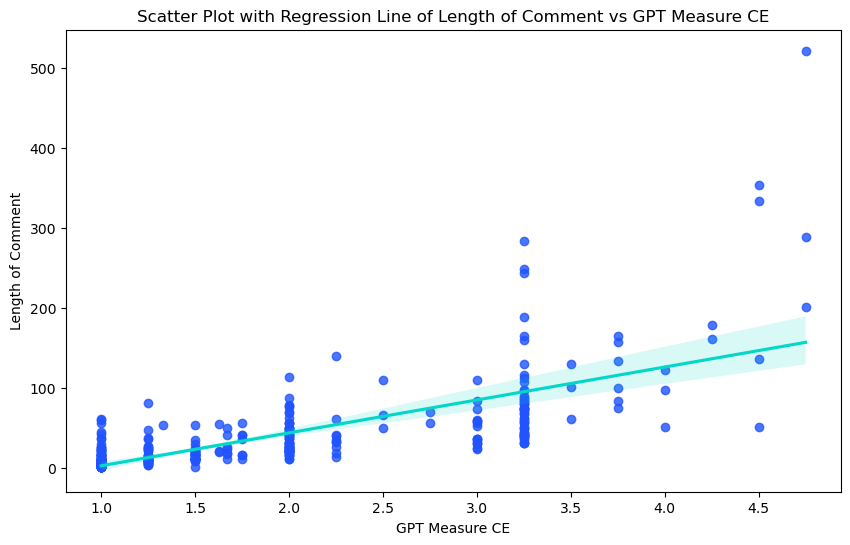

In [278]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Assuming 'final_df_cleaned' is your DataFrame
# Replace the below line with your actual DataFrame
# final_df_cleaned = ...

# Ensure both columns are in a suitable format for correlation
final_df_cleaned['GPT_Measure_CE'] = pd.to_numeric(final_df_cleaned['GPT_Measure_CE'], errors='coerce')
final_df_cleaned['Length'] = pd.to_numeric(final_df_cleaned['Length'], errors='coerce')

# Drop NaN values for a clean correlation calculation
cleaned_for_correlation = final_df_cleaned.dropna(subset=['GPT_Measure_CE', 'Length'])

# Pearson Correlation
correlation, p_value = stats.pearsonr(cleaned_for_correlation['GPT_Measure_CE'], cleaned_for_correlation['Length'])

print("Pearson Correlation Coefficient:", correlation)
print("P-value:", p_value)

# Scatter Plot with Regression Line
plt.figure(figsize=(10, 6))
sns.regplot(x='GPT_Measure_CE', y='Length', data=final_df_cleaned, 
            scatter_kws={'color': '#2154ff'}, line_kws={'color': '#03d7c7'})

plt.xlabel('GPT Measure CE')
plt.ylabel('Length of Comment')
plt.title('Scatter Plot with Regression Line of Length of Comment vs GPT Measure CE')

plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'final_df_cleaned' is your DataFrame
# Replace the below line with your actual DataFrame
# final_df_cleaned = ...

# Convert GPT_Measure_CE to float
final_df_cleaned['GPT_Measure_CE'] = pd.to_numeric(final_df_cleaned['GPT_Measure_CE'], errors='coerce')

# Creating the histogram with the specified color
plt.figure(figsize=(10, 6))
plt.hist(final_df_cleaned['GPT_Measure_CE'].dropna(), bins=7, range=(1,7), color='#5279ff', edgecolor='black')

# Adding labels and title
plt.xlabel('GPT Measure CE')
plt.ylabel('Frequency')
plt.title('Histogram of GPT Measure CE')

# Optionally, set the x-axis limits
plt.xlim(1, 7)

# Display the plot
plt.show()


Number of data points used for the plot: 406


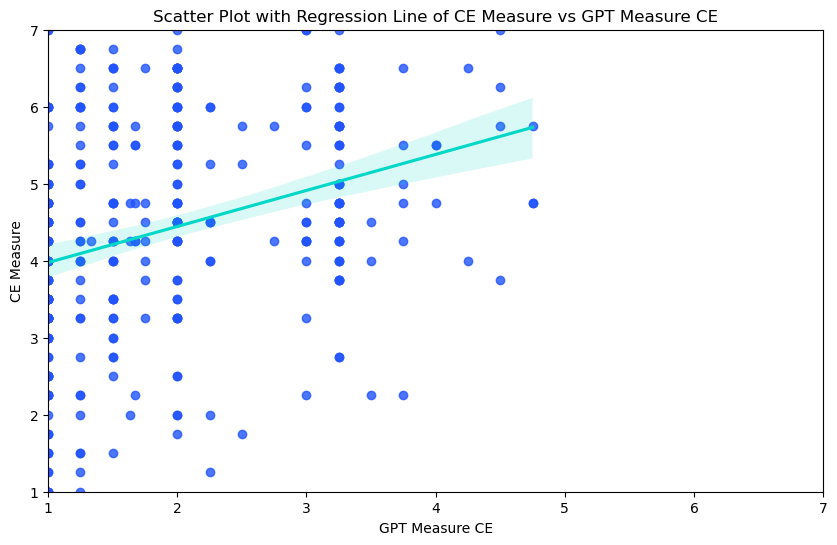

In [272]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_df_cleaned' is your DataFrame
# Replace the below line with your actual DataFrame
# final_df_cleaned = ...

# Function to check if a value can be converted to float
def is_float(value):
    if value is None:
        return False
    try:
        float(value)
        return True
    except ValueError:
        return False

# Filter rows where both CE_measure and GPT_Measure_CE can be converted to float
filtered_df = final_df_cleaned[
    final_df_cleaned['CE_measure'].apply(is_float) & 
    final_df_cleaned['GPT_Measure_CE'].apply(is_float)
].copy()  # Create a copy here

# Now convert these columns to float without warning
filtered_df['CE_measure'] = filtered_df['CE_measure'].astype(float)
filtered_df['GPT_Measure_CE'] = filtered_df['GPT_Measure_CE'].astype(float)


# Counting the number of data points
num_data_points = len(filtered_df)
print("Number of data points used for the plot:", num_data_points)

# Creating the scatter plot with a regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='GPT_Measure_CE', y='CE_measure', data=filtered_df, 
            scatter_kws={'color': '#2154ff'}, line_kws={'color': '#03d7c7'})

# Optionally, set the axes limits
plt.xlim(1, 7)
plt.ylim(1, 7)

# Adding labels and title
plt.xlabel('GPT Measure CE')
plt.ylabel('CE Measure')
plt.title('Scatter Plot with Regression Line of CE Measure vs GPT Measure CE')

# Display the plot
plt.show()


In [13]:
import pandas as pd

# Angenommen, final_df_cleaned ist Ihr DataFrame
# final_df_cleaned = ...

# Zählen der Werte "forced" und "voluntary" in der Spalte "CommentType"
count_forced = final_df_cleaned['CommentType'].value_counts().get('forced', 0)
count_voluntary = final_df_cleaned['CommentType'].value_counts().get('voluntary', 0)

print("Anzahl von 'forced':", count_forced)
print("Anzahl von 'voluntary':", count_voluntary)

Anzahl von 'forced': 339
Anzahl von 'voluntary': 67


In [17]:
import pandas as pd

# Angenommen, final_df_cleaned ist Ihr DataFrame
# final_df_cleaned = ...

# Zählen der Werte 1, 2 und 3 in der Spalte "SD01"
count_1 = final_df_cleaned['SD01'].value_counts().get(1, 0)
count_2 = final_df_cleaned['SD01'].value_counts().get(2, 0)
count_3 = final_df_cleaned['SD01'].value_counts().get(3, 0)
count_4 = final_df_cleaned['SD01'].value_counts().get(-1, 0)

print("Anzahl von '1':", count_1)
print("Anzahl von '2':", count_2)
print("Anzahl von '3':", count_3)
print("Anzahl von '-1':", count_4)

# Berechnung der statistischen Kennzahlen für die Spalte "SD02_01"
mean_age = final_df_cleaned['SD02_01'].mean()
std_dev_age = final_df_cleaned['SD02_01'].std()
min_age = final_df_cleaned['SD02_01'].min()
max_age = final_df_cleaned['SD02_01'].max()

# Ausgabe im APA-Stil
print(f"Alter: M = {mean_age:.2f}, SD = {std_dev_age:.2f}, Min = {min_age}, Max = {max_age}")


Anzahl von '1': 227
Anzahl von '2': 175
Anzahl von '3': 3
Anzahl von '-1': 1
Alter: M = 29.03, SD = 10.41, Min = 15.0, Max = 76.0


BA01
1    91
7    76
8    67
5    52
4    48
6    29
2    29
3    14
Name: count, dtype: int64


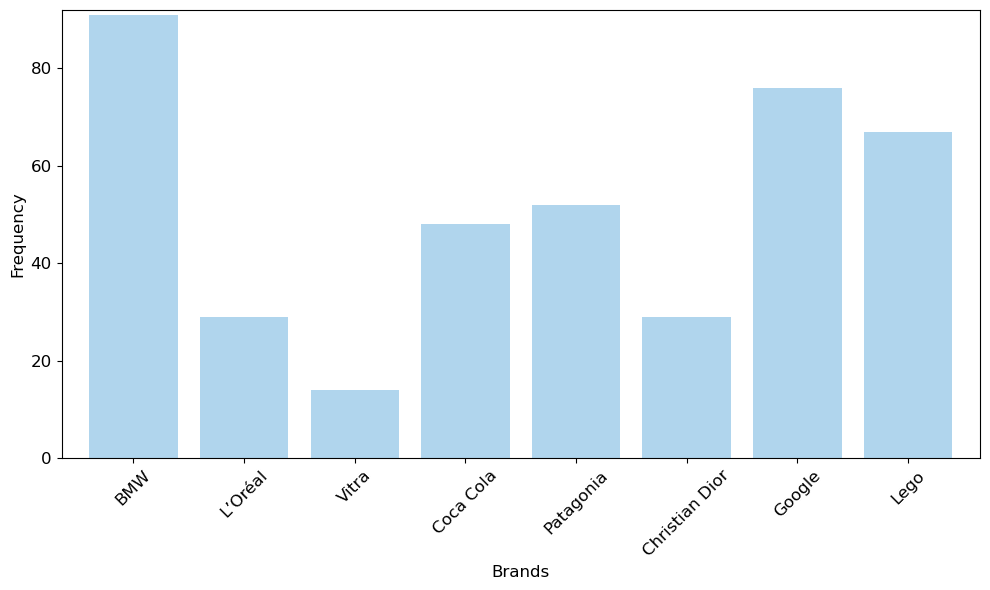

In [33]:
# Zählen der Häufigkeit jedes Wertes in der Spalte "BA01"
brand_selection_counts = final_df_cleaned['BA01'].value_counts()

print(brand_selection_counts)

# Anpassung des Histogramm-Codes mit benutzerdefinierten Beschriftungen für die X-Achse

import matplotlib.pyplot as plt
import pandas as pd

# Angenommen, final_df_cleaned ist Ihr DataFrame
# final_df_cleaned = ...

# Zählen der Häufigkeit jedes Wertes in der Spalte "BA01"
brand_selection_counts = final_df_cleaned['BA01'].value_counts().sort_index()

# Bestimmung des maximalen Häufigkeitswertes für die Skalierung der Y-Achse
max_count = brand_selection_counts.max()

# Benutzerdefinierte Beschriftungen für die X-Achse
x_labels = ['BMW', 'L’Oréal', 'Vitra', 'Coca Cola', 'Patagonia', 'Christian Dior', 'Google', 'Lego']

# Erstellen des Histogramms im APA-Format
plt.figure(figsize=[10,6])
brand_selection_counts.plot(kind='bar', color='#b0d5ed', width=0.8)
plt.xlabel('Brands', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(8), labels=x_labels, rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max_count + 1)
plt.tight_layout()  # Stellt sicher, dass alles ordentlich angeordnet ist
plt.show()




